In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm


Populating the interactive namespace from numpy and matplotlib






---




# Image classification on CIFAR-10

### Preliminaries information:
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10
dataset. If you are not comfortable with PyTorch from the previous lecture and discussion materials, use the tutorials at http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html and make sure you
are familiar with tensors, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`),
ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

For this problem, it is highly recommended that you copy and modify the existing network code produced in
the tutorial *Training a classifier*. You should not be coding this network from scratch!



- Each network $f$ maps an image $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$ (3 channels for RGB) to an output $f(x^{\rm in}) = x^{\rm out} \in \mb{R}^{10}$. The class label is predicted as $\arg\max_{i=0,1,\dots,9} x_{i}^{\rm out}$.

- The network is trained via multiclass cross-entropy loss (log of softmax function).  Specifically, for an input image and label pair $(x^{\rm in} , c)$ where $c\in \{0,\dots, 9\}$. If the network’s
output layer is $x^{\rm out} \in \mb{R}^{10}$, the loss $-\log\left(\frac{\exp(x_c^{\rm out})}{\sum_{c'} \exp(x_{c'}^{\rm out})}\right)$.

- For computational efficiency reasons, this particular network considers mini-batches of images per training
step meaning the network actually maps $B=4$ images per feed-forward so that $\tilde{x}^{\rm in}\in\mb{R}^{B\times 32 \times 32 \times 3}$ and $\tilde{x}^{\rm out}\in\mb{R}^{B\times 10}$.  This is ignored in the network descriptions below but it is something to be aware of.

- Create a validation dataset by appropriately partitioning the train dataset. **Hint**: look at the documentation for `torch.utils.data.random\_split`. Make sure to tune hyperparameters like network architecture and step size on the validation dataset. Do **NOT** validate your hyperparameters on the test dataset.

- Modify the training code such that at the end of each epoch (one pass over the training data) it computes and prints the training and test classification accuracy.

- The cross-entropy loss for a neural network is, in general, non-convex. This means that the optimization
method may converge to different local minima based on different hyperparameters of the optimization
procedure (e.g., stepsize). Usually one can find a good setting for these hyperparameters by just observing
the relative progress of training over the first epoch or two (how fast is it decreasing) but you are warned
that early progress is not necessarily indicative of the final convergence value (you may converge quickly to a poor local minimum whereas a different step size could have poor early performance but converge to
a better final value).

- While one would usually train a network for hundreds of epochs to reach convergence and maximize accuracy, this can be prohibitively time-consuming, so feel free to train for just a a dozen or so epochs.


**Your Task:**
For all of the following,
- Apply a **hyperparameter tuning method** (manually by
hand, grid search, random search, etc.) using the
validation set

- Report the hyperparameter configurations you evaluated and the best set of hyperparameters
from this set.  

- Plot the training and validation classification accuracy as a function of iteration. Produce
a separate line or plot for each hyperparameter configuration evaluated (please try to use multiple lines in a single plot to keep the number of figures minimal).

- Finally, evaluate your best set of
hyperparameters on the test data and report the accuracy.



The number of hyperparameters to tune, combined with the slow training times, will hopefully give
you a taste of how difficult it is to construct networks with good generalization performance. It should be emphasized that the
networks we constructed are **tiny**.
State-of-the-art networks can have dozens of layers, each with their own hyperparameters to tune. Additional
hyperparameters you are welcome to play with if you are so inclined, include: changing the activation
function, replace max-pool with average-pool, adding more convolutional or fully connected layers, and
experimenting with batch normalization or dropout.


Here are the network architectures you will construct and compare.
Before you jump into tuning, it is better to write  separate train and evaluation functions.

---







In [ ]:
sns.set()
torch.manual_seed(592)
np.random.seed(592)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# it may takes while to download the data, please try this code several times.
def prepare_dataset(batch_size=64, train_val_split_ratio=0.9):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(cifar10_set) * train_val_split_ratio)
    val_size   = len(cifar10_set) - train_size

    cifar10_trainset, cifar10_valset = torch.utils.data.random_split(cifar10_set, [train_size, val_size])
    cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar10_valset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


## Finish the following code
Please finish the functions of `train` and `evaluation`. You must use these two functions in the later evaluation. Fail to do so will result zero point in your project.

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size):
    """Trains a model for n epochs using given optimizer, and then records
    validation and training accuracies, validation and training losses.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} => '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}% | '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Move the return statement outside of the outer loop
    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
def evaluation(model, test_loader, criterion):
    """ Calculate and print test accuracy and test losses.
    """
    model.eval()
    total_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return avg_test_loss, test_accuracy

##  Fully-connected output, no hidden layers (logistic regression)
We begin with the simplest network
possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is,
conceptually it could be written as
\begin{align*}
    x^{\rm out} &= W \text{vec}(x^{\rm in}) +b
\end{align*}
where $x^{\rm out} \in \mb{R}^{10}$, $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$, $W \in \mb{R}^{10 \times 3072}$, $b \in \mb{R}^{10}$ since $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mb{R}^{a \times b \times c}$, we let $\text{vec}(x) \in \mb{R}^{a b c}$ be the reshaped form of the tensor into a vector (in an arbitrary but consistent pattern).   There is no required benchmark testing accuracy for this part.

In [ ]:
# Assuming the LogisticRegression class is already defined as provided in your snippet
# Define constants
input_size = 32 * 32 * 3  # CIFAR-10 images are 32x32 pixels with 3 color channels
num_classes = 10  # There are 10 classes in CIFAR-10
learning_rate = 0.001  # Define a suitable learning rate
epochs = 15  # Define the number of epochs to train for

# Initialize the model
model = LogisticRegression(input_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Load the dataset using the prepare_dataset function
train_loader, val_loader, test_loader = prepare_dataset(batch_size=64, train_val_split_ratio=0.9)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Train the model using the train function
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs, 64)


Epoch 1/15 => Training Loss: 2.0110, Training Accuracy: 29.24% | Validation Loss: 1.9112, Validation Accuracy: 34.68%
Epoch 2/15 => Training Loss: 1.8797, Training Accuracy: 35.86% | Validation Loss: 1.8494, Validation Accuracy: 38.20%
Epoch 3/15 => Training Loss: 1.8390, Training Accuracy: 37.44% | Validation Loss: 1.8254, Validation Accuracy: 38.46%
Epoch 4/15 => Training Loss: 1.8162, Training Accuracy: 38.32% | Validation Loss: 1.8080, Validation Accuracy: 39.04%
Epoch 5/15 => Training Loss: 1.8004, Training Accuracy: 38.78% | Validation Loss: 1.7999, Validation Accuracy: 39.88%
Epoch 6/15 => Training Loss: 1.7899, Training Accuracy: 39.35% | Validation Loss: 1.7913, Validation Accuracy: 40.24%
Epoch 7/15 => Training Loss: 1.7786, Training Accuracy: 39.59% | Validation Loss: 1.7784, Validation Accuracy: 40.38%
Epoch 8/15 => Training Loss: 1.7707, Training Accuracy: 40.02% | Validation Loss: 1.7729, Validation Accuracy: 40.04%
Epoch 9/15 => Training Loss: 1.7639, Training Accuracy: 

In [ ]:
# Evaluate the model using the evaluation function
test_loss, test_accuracy = evaluation(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.7487, Test Accuracy: 40.28%
Test Loss: 1.7487, Test Accuracy: 40.28%


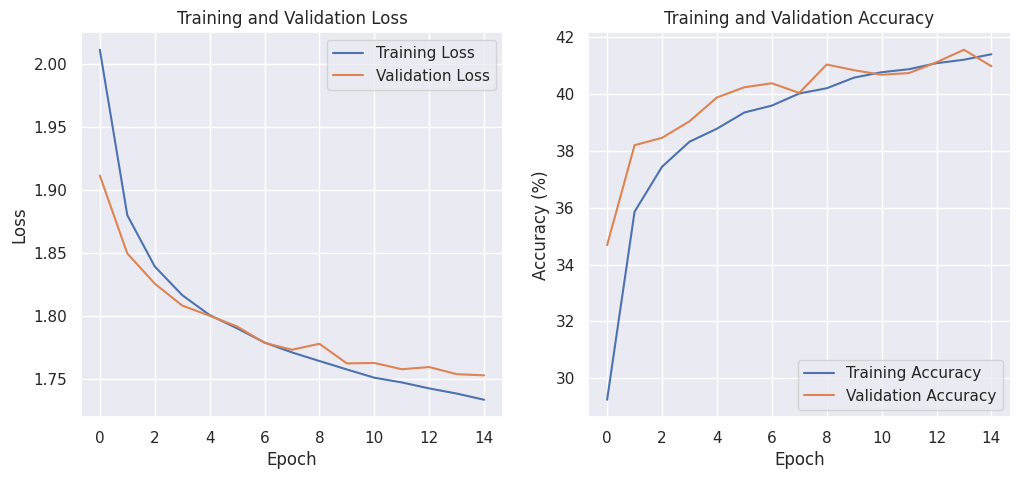

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Call the plot function
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

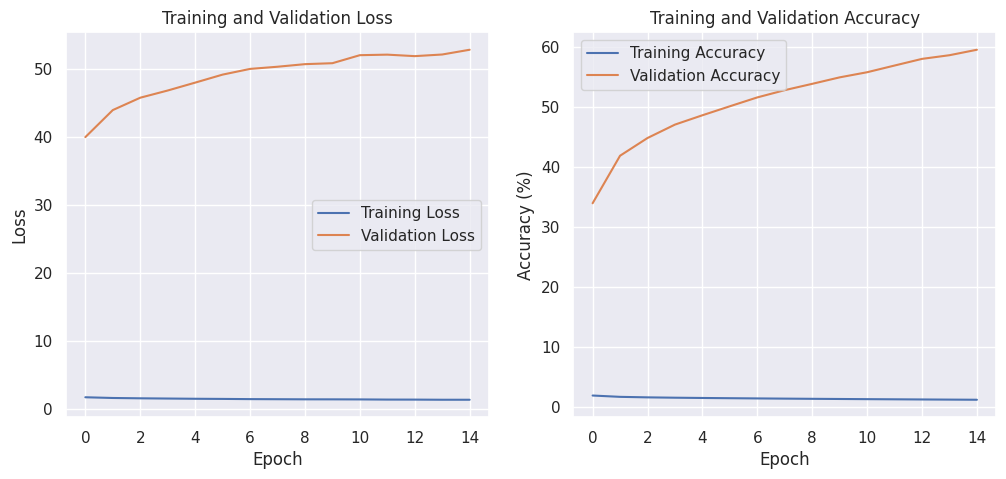

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Discuss your findings:



---


## Fully-connected output, 1 fully-connected hidden layer

We will have one hidden layer denoted as $x^{\rm hidden} \in \mb{R}^{M}$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The non-linearity applied to the hidden layer will be the **relu** ($\mathrm{relu}(x) = \max\{0,x\}$, elementwise). This network can be written as

\begin{align*}
    x^{\rm out} &= W_2 \mathrm{relu}(W_1 \text{vec}(x^{\rm in}) +b_1) + b_2
\end{align*}

where $W_1 \in \mb{R}^{M \times 3072}$, $b_1 \in \mb{R}^M$, $W_2 \in \mb{R}^{10 \times M}$, $b_2 \in \mb{R}^{10}$.  Tune the different hyperparameters and train for
a sufficient number of epochs to achieve a testing accuracy of at least 50%. Provide the hyperparameter
configuration used to achieve this performance.



In [ ]:
#  your code starts here
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

# Define the neural network architecture
class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnected, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define constants
input_size = 32 * 32 * 3  # Flattened size of CIFAR-10 images
output_size = 10  # Number of classes in CIFAR-10
epochs = 15
batch_size = 64
hidden_size = 512  # Start with a hidden layer size of 512

In [ ]:
# Create the model, loss function, and optimizer
model = FullyConnected(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the logistic regression model
train_accuracies, train_losses, val_accuracies, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Epoch 1/15 => Training Loss: 1.8930, Training Accuracy: 33.94% | Validation Loss: 1.7327, Validation Accuracy: 40.02%
Epoch 2/15 => Training Loss: 1.6722, Training Accuracy: 41.87% | Validation Loss: 1.6265, Validation Accuracy: 44.00%
Epoch 3/15 => Training Loss: 1.5866, Training Accuracy: 44.82% | Validation Loss: 1.5781, Validation Accuracy: 45.82%
Epoch 4/15 => Training Loss: 1.5294, Training Accuracy: 47.06% | Validation Loss: 1.5440, Validation Accuracy: 46.88%
Epoch 5/15 => Training Loss: 1.4848, Training Accuracy: 48.61% | Validation Loss: 1.5105, Validation Accuracy: 48.04%
Epoch 6/15 => Training Loss: 1.4460, Training Accuracy: 50.11% | Validation Loss: 1.4893, Validation Accuracy: 49.22%
Epoch 7/15 => Training Loss: 1.4092, Training Accuracy: 51.59% | Validation Loss: 1.4595, Validation Accuracy: 50.06%
Epoch 8/15 => Training Loss: 1.3750, Training Accuracy: 52.80% | Validation Loss: 1.4450, Validation Accuracy: 50.38%
Epoch 9/15 => Training Loss: 1.3439, Training Accuracy: 

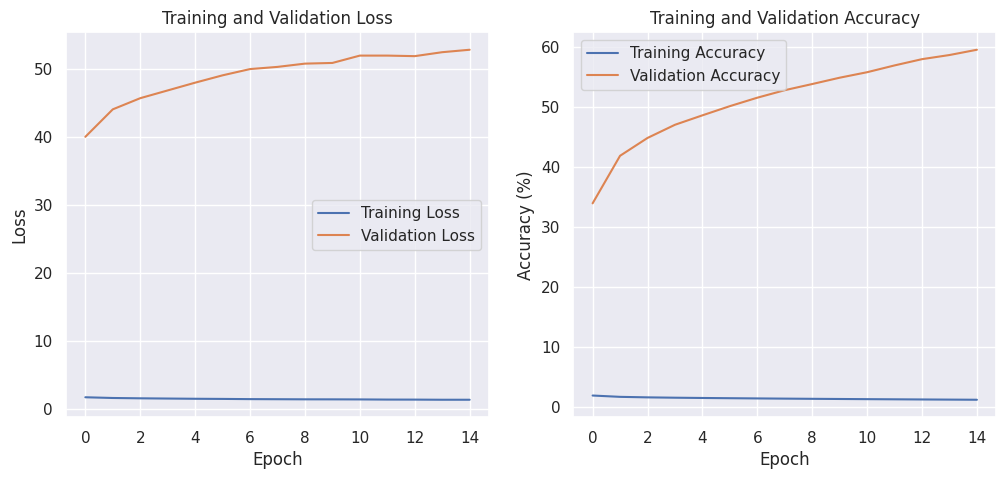

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Discuss your findings:



---


## Convolutional layer with max-pool and fully-connected output

For a convolutional layer $W_1$ with filters of size $k \times k \times 3$, and $M$ filters (reasonable choices are $M=100$, $k=5$), we have that $\mathrm{Conv2d}(x^{\rm in}, W_1) \in \mb{R}^{(33-k) \times (33-k) \times M}$.

- Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as $\mathrm{Conv2d}(x^{\rm in}, W) + b_1$ where $b_1$ is parameterized in $\mb{R}^M$. Apply a **relu** activation to the result of the convolutional layer.

-  Next, use a max-pool of size $N \times N$ (a reasonable choice is $N=14$ to pool to $2 \times 2$ with $k=5$) we have that $\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm in}, W_1)+b_1)) \in \mb{R}^{\lfloor\frac{33-k}{N}\rfloor \times \lfloor\frac{33-k}{N}\rfloor \times M}$.

- We will then apply a fully-connected layer to the output to get a final network given as
\begin{align*}
          x^{\rm output} = W_2 \text{vec}(\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm input}, W_1)+b_1))) + b_2
\end{align*}
where $W_2 \in \mb{R}^{10 \times M (\lfloor\frac{33-k}{N}\rfloor)^2}$, $b_2 \in \mb{R}^{10}$.


The parameters $M, k, N$ (in addition to the step size and momentum) are all hyperparameters, but you
can choose a reasonable value. Tune the different hyperparameters (number of convolutional filters, filter
sizes, dimensionality of the fully-connected layers, stepsize, etc.) and train for a sufficient number of
epochs to achieve a validation accuracy of **at least 70%**. Provide the hyperparameter configuration used
to achieve this performance. Make sure to save this model so that you can do the next part.


In [ ]:
#  Q3 your code starts here
class CNN(nn.Module):
    def __init__(self, M, k, N):
        super(CNN, self).__init__()
        self.conv_layer = nn.Conv2d(3, M, kernel_size=k, padding=k//2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=N, stride=N)
        self.flatten = nn.Flatten()
        self.fc_layer = nn.Linear(M * (32//N) * (32//N), 10)

    def forward(self, x):
        x = x.to(self.conv_layer.weight.device)
        x = self.conv_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc_layer(x)
        return x
M = 1024
k = 5
N = 14
learning_rate = 0.005
epochs = 30


In [ ]:
model = CNN(M, k, N)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_loader, val_loader, test_loader = prepare_dataset()

train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size=64)

evaluation(model, test_loader, criterion)

torch.save(model.state_dict(), 'cnn_model.pth')

100%|██████████| 170498071/170498071 [00:06<00:00, 28313071.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` are recorded during training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


# Discuss your findings:



---


## More tuning

Return to the original network you were left with at the end of the tutorial Training
a classifier. (Note that this is not the network above.) Tune the different hyperparameters
(number of convolutional filters, filter sizes, dimensionality of the fully-connected layers, stepsize, etc.) and
train for a sufficient number of iterations to achieve a *train accuracy* of **at least 87%**. You may not modify
the core structure of the model (i.e., adding additional layers). Provide the hyperparameter configuration
used to achieve this performance. Make sure to save this model so that you can do the next part (see
the Training a classifier tutorial for details on how to do this).

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Instantiate the model
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Loss and optimizer with adjusted learning rate and weight decay
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)  # Adjust learning rate and add weight decay

train_loader, val_loader, test_loader = prepare_dataset()

# Train the logistic regression model
train_accuracies, train_losses, val_accuracies, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs = 30, batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 => Training Loss: 2.0384, Training Accuracy: 24.55% | Validation Loss: 1.6696, Validation Accuracy: 38.40%
Epoch 2/30 => Training Loss: 1.5776, Training Accuracy: 42.17% | Validation Loss: 1.4892, Validation Accuracy: 45.42%
Epoch 3/30 => Training Loss: 1.4127, Training Accuracy: 48.81% | Validation Loss: 1.3249, Validation Accuracy: 51.80%
Epoch 4/30 => Training Loss: 1.3032, Training Accuracy: 53.37% | Validation Loss: 1.3501, Validation Accuracy: 51.92%
Epoch 5/30 => Training Loss: 1.2222, Training Accuracy: 56.35% | Validation Loss: 1.2560, Validation Accuracy: 54.70%
Epoch 6/30 => Training Loss: 1.1547, Training Accuracy: 58.89% | Validation Loss: 1.2040, Validation Accuracy: 56.86%
Epoch 7/30 => Training Loss: 1.0959, Training Accuracy: 61.28% | Validation Loss: 1.1545, Validation Accuracy: 59.42%
Epoch 8/30 => Training Loss: 1.0424, Training Accuracy: 63.11% | Validation Loss: 1.1175, Validati

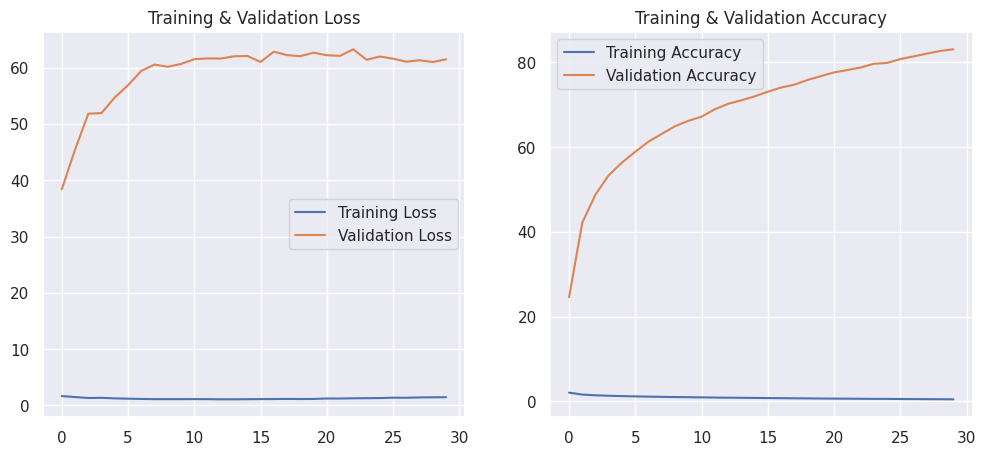

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies` are recorded during training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # Increased number of filters
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)  # Increased number of filters
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Wider fully connected layer
        self.drop = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Instantiate the model
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Define optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader, val_loader, test_loader = prepare_dataset()

# Train the logistic regression model
train_accuracies, train_losses, val_accuracies, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs = 30, batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 => Training Loss: 1.5306, Training Accuracy: 43.62% | Validation Loss: 1.2306, Validation Accuracy: 55.28%
Epoch 2/30 => Training Loss: 1.2146, Training Accuracy: 56.29% | Validation Loss: 1.0056, Validation Accuracy: 65.00%
Epoch 3/30 => Training Loss: 1.0734, Training Accuracy: 61.86% | Validation Loss: 0.9519, Validation Accuracy: 67.30%


In [ ]:
# Adding Batch Normalization to the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_correct, total_train = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(100 * total_train_correct / total_train)

        # Validation phase
        model.eval()
        total_val_loss, total_val_correct, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                total_val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(total_val_loss / len(val_loader))
        val_accuracy = 100 * total_val_correct / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} => '
              f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}% | '
              f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

        scheduler.step()

        # Check for early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, patience=10)
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test data
test_loss, test_accuracy = evaluation(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


# Discuss your findings: